## Baseline: análisis de estrategias para InceptionV3

In [27]:
import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import pickle
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido '{project_root}' a sys.path")

from src.architectures import build_model

PROCESSED_DATA_PATH = '../data/processed/'
IMAGE_ROOT_DIR = '../data/raw/color'
OUTPUTS_PATH = '../outputs/'
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 38
EPOCHS = 15
MODEL_NAME = 'InceptionV3' 

balanced_train_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'df_train_balanced.csv'))
df_splitted = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))
train_df = df_splitted[df_splitted['split'] == 'train']
val_df = df_splitted[df_splitted['split'] == 'valid']


#### DEFINICIÓN DE AUMENTACIONES Y GENERADORES

In [28]:
# Estrategia "Sin Color" (Geométrica)
transform_geometric_only = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.2, rotate_limit=25, border_mode=cv2.BORDER_REPLICATE, p=0.75),
    A.Affine(shear={'x': (-12, 12), 'y': (-12, 12)}, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(224, 224, always_apply=True)])

# Estrategia "Con Color" (Geométrica + Color)
transform_geometric_and_color = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(224, 224, always_apply=True),])

def apply_albumentations(image, transform):
    image = (image * 255).astype(np.uint8)
    return transform(image=image)['image'].astype(np.float32) / 255.0

datagen_geometric = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_geometric_only))
datagen_color = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_geometric_and_color))
datagen_val = ImageDataGenerator(rescale=1./255)

flow_kwargs = {'directory': IMAGE_ROOT_DIR, 'x_col': 'relative_path', 'y_col': 'class', 'target_size': TARGET_SIZE, 'batch_size': BATCH_SIZE, 'class_mode': 'categorical'}

train_gen_unbalanced_geometric = datagen_geometric.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
train_gen_unbalanced_color = datagen_color.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
train_gen_balanced_geometric = datagen_geometric.flow_from_dataframe(dataframe=balanced_train_df, shuffle=True, **flow_kwargs)
train_gen_balanced_color = datagen_color.flow_from_dataframe(dataframe=balanced_train_df, shuffle=True, **flow_kwargs)
val_generator = datagen_val.flow_from_dataframe(dataframe=val_df, shuffle=False, **flow_kwargs)


Found 38013 validated image filenames belonging to 38 classes.
Found 38013 validated image filenames belonging to 38 classes.
Found 146452 validated image filenames belonging to 38 classes.
Found 146452 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


### Experimentos

In [29]:
experiments = [
    {'name': 'Unbalanced_Geometric', 'generator': train_gen_unbalanced_geometric},
    {'name': 'Unbalanced_Color',     'generator': train_gen_unbalanced_color},
    {'name': 'Balanced_Geometric',   'generator': train_gen_balanced_geometric},
    {'name': 'Balanced_Color',       'generator': train_gen_balanced_color},
]

histories = {} 

for exp in experiments:
    exp_name = f"exp_{MODEL_NAME}_{exp['name']}"
    print(f"\n{'='*25}\nIniciando Experimento: {exp_name}\n{'='*25}")

    exp_output_dir = os.path.join(OUTPUTS_PATH, exp_name)
    os.makedirs(exp_output_dir, exist_ok=True)

    model = build_model(model_name=MODEL_NAME, num_classes=NUM_CLASSES, fine_tune=False)
    
    # --- LISTA DE CALLBACKS ACTUALIZADA ---
    callbacks = [
        ModelCheckpoint(
            os.path.join(exp_output_dir, 'best_model.keras'), 
            monitor='val_accuracy', 
            save_best_only=True, 
            mode='max',
            verbose=1),

        EarlyStopping(
            monitor='val_accuracy',     
            patience=4,            
            verbose=1,
            mode='max',
            restore_best_weights=True ),
        CSVLogger(os.path.join(exp_output_dir, 'training_log.csv'))]
    
    history = model.fit(
        exp['generator'],
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks)
    histories[exp['name']] = pd.DataFrame(history.history)

print("\nTODOS LOS EXPERIMENTOS HAN FINALIZADO.")



Iniciando Experimento: exp_InceptionV3_Unbalanced_Geometric
Modelo InceptionV3 construido. Capas base entrenables: False
Epoch 1/15


/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5929 - loss: 1.4964
Epoch 1: val_accuracy improved from -inf to 0.52366, saving model to ../outputs/exp_InceptionV3_Unbalanced_Geometric/best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 76s 55ms/step - accuracy: 0.5929 - loss: 1.4961 - val_accuracy: 0.5237 - val_loss: 1.8095
Epoch 2/15
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7690 - loss: 0.7463
Epoch 2: val_accuracy improved from 0.52366 to 0.53029, saving model to ../outputs/exp_InceptionV3_Unbalanced_Geometric/best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.7690 - loss: 0.7463 - val_accuracy: 0.5303 - val_loss: 1.7565
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7851 - loss: 0.6755
Epoch 3: val_accuracy improved from 0.53029 to 0.55828, saving model to ../outputs/exp_InceptionV3_Unbalanced_Geometric/best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.7851 - loss: 0.6755 - val_accuracy:


Generando matriz de gráficos comparativos con eje de Loss unificado...
Límite del eje Y para todos los gráficos de Loss será: 2.35


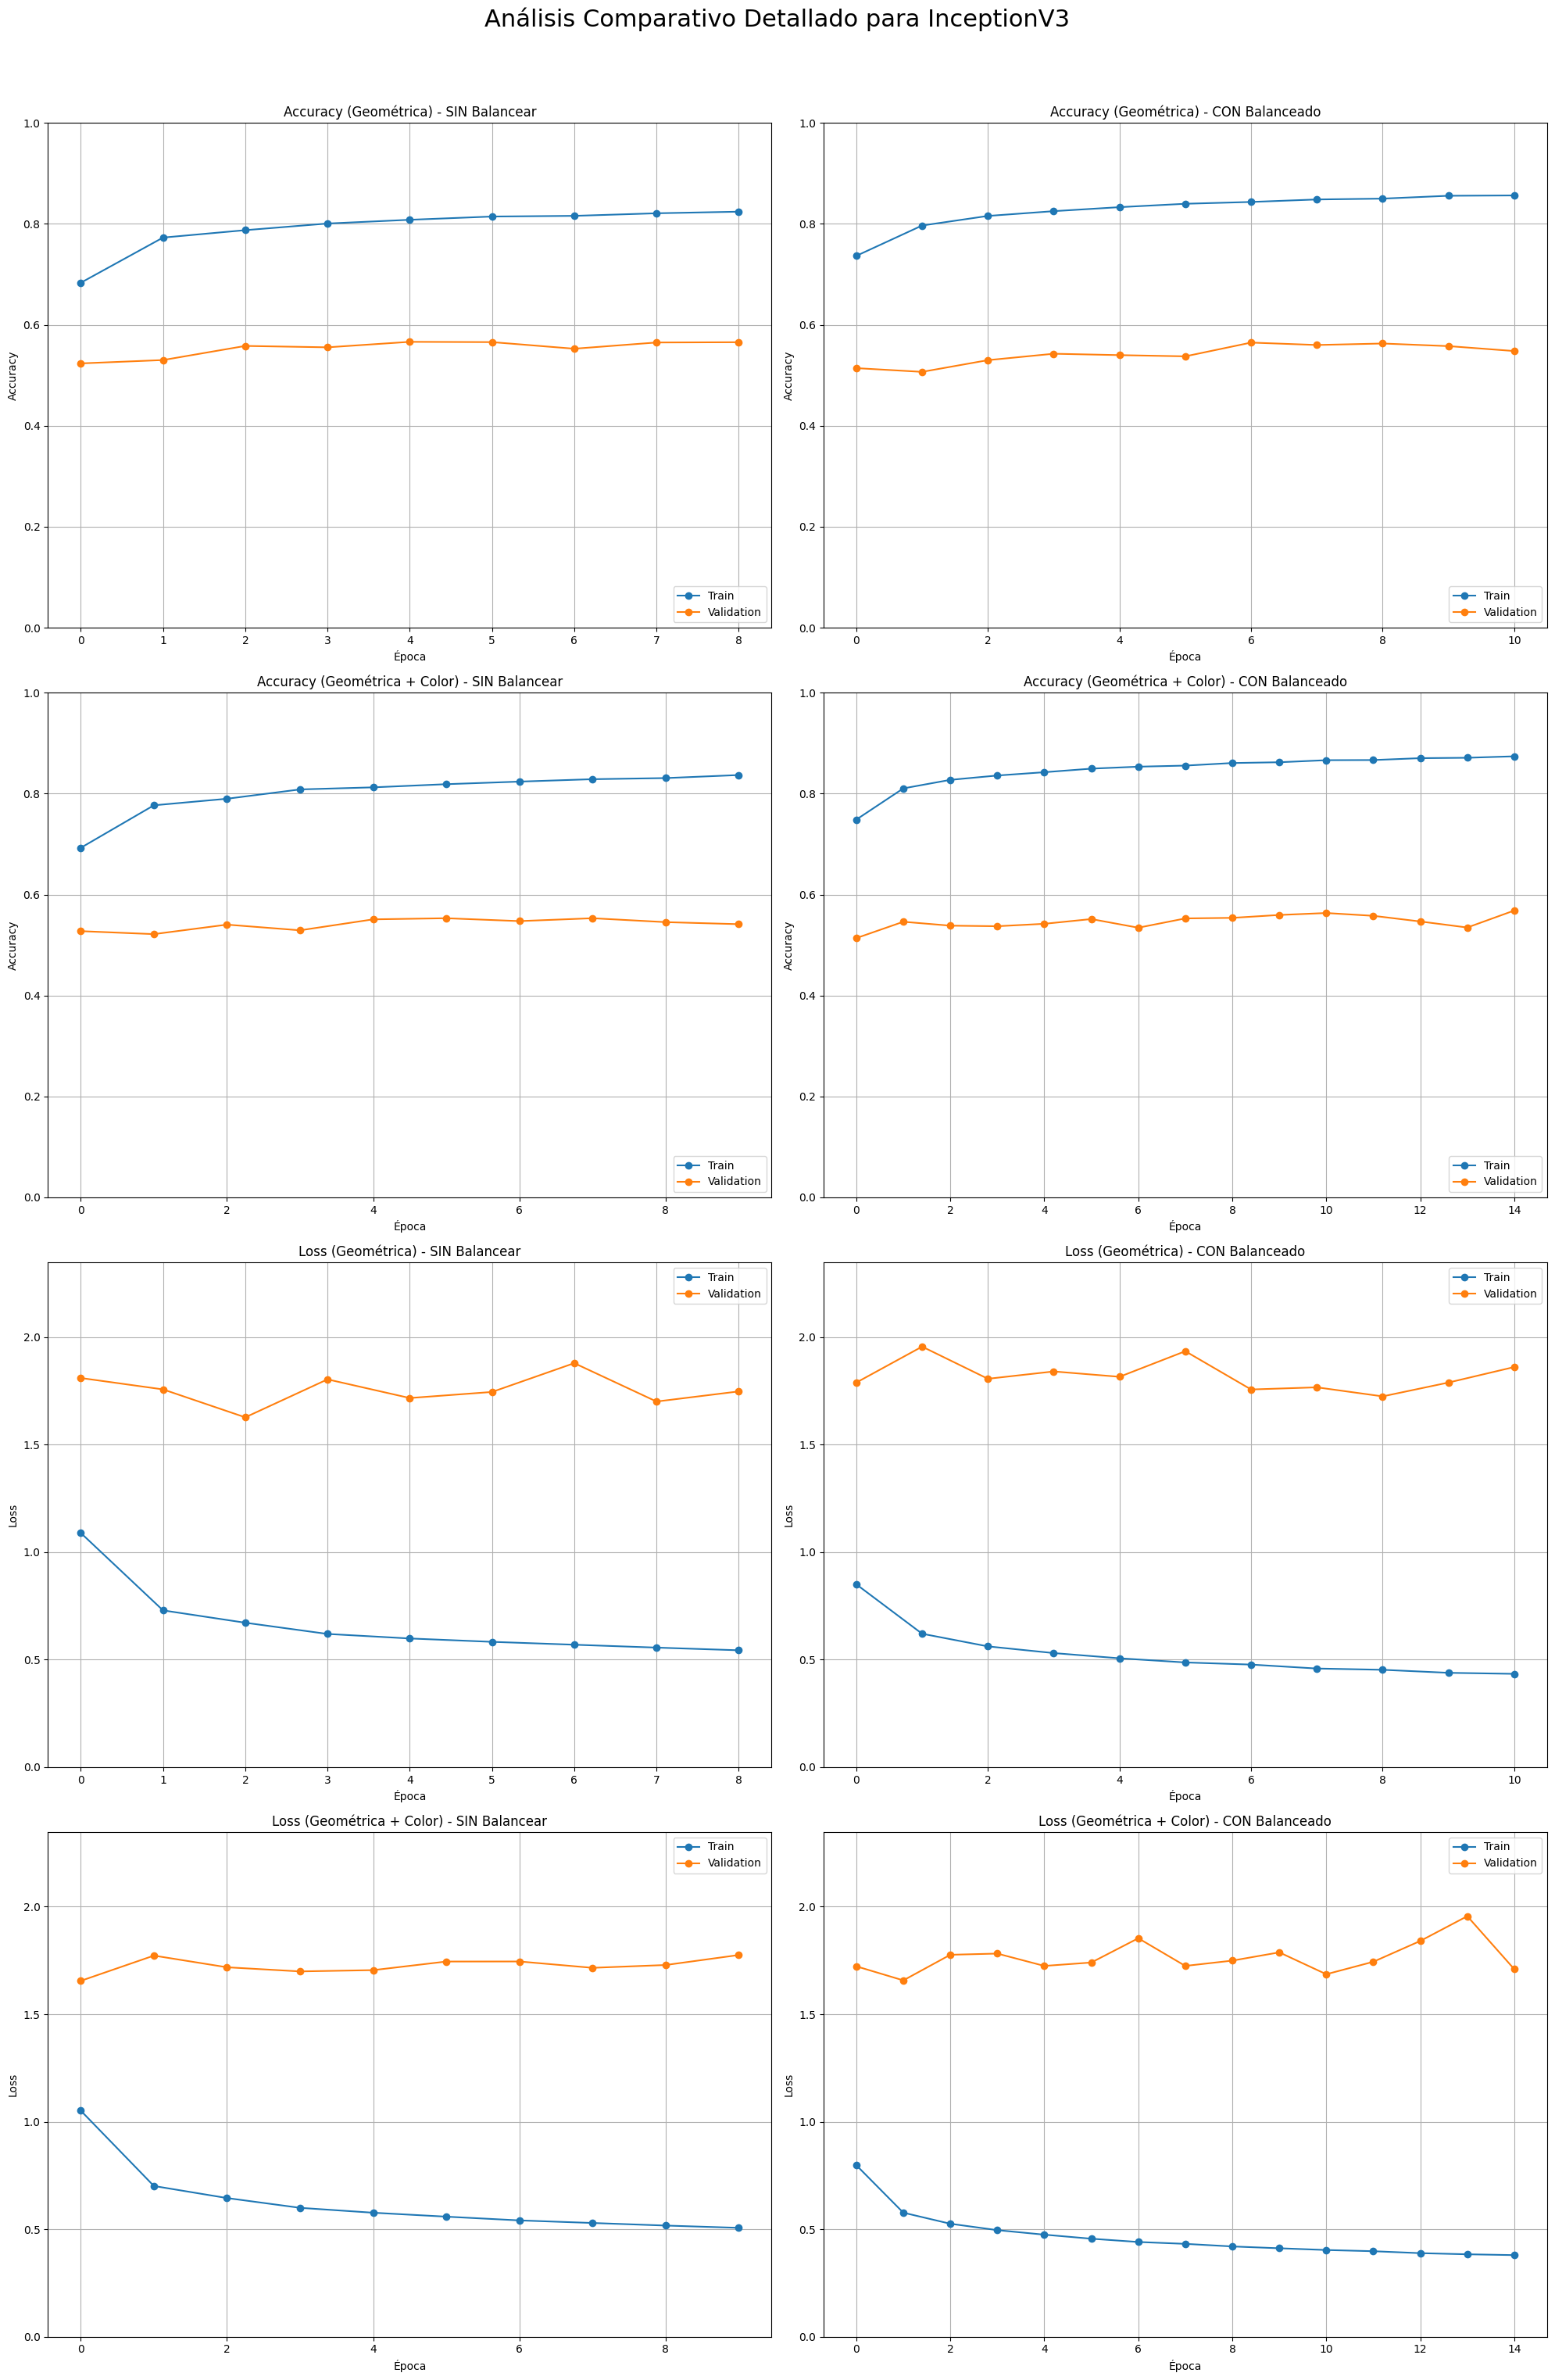

In [30]:
# --- 5. COMPARACIÓN VISUAL FINAL (con eje Y de Loss unificado) ---

print("\nGenerando matriz de gráficos comparativos con eje de Loss unificado...")

# --- Paso previo: Calcular el MÁXIMO LOSS global entre todos los experimentos ---
overall_max_loss = 0
for name, history_df in histories.items():
    if history_df is not None:
        # Encontrar el máximo de esta instancia (entre train y validation)
        max_train_loss = history_df['loss'].max()
        max_val_loss = history_df['val_loss'].max()
        current_max = max(max_train_loss, max_val_loss)
        # Actualizar el máximo global si el actual es mayor
        if current_max > overall_max_loss:
            overall_max_loss = current_max

# Definimos el límite superior del eje Y para todos los gráficos de loss (con un 20% de margen)
loss_y_limit = overall_max_loss * 1.2
print(f"Límite del eje Y para todos los gráficos de Loss será: {loss_y_limit:.2f}")


# --- Creación de la figura y los ejes ---
fig, axes = plt.subplots(4, 2, figsize=(20, 32))
fig.suptitle(f'Análisis Comparativo Detallado para {MODEL_NAME}', fontsize=22)


# --- Función auxiliar para dibujar las curvas (ACTUALIZADA) ---
def plot_curves(ax, history_df, metric_name, title, y_limit=None):
    """Dibuja las curvas y ajusta los ejes Y según la métrica y un límite opcional."""
    if history_df is None:
        # ... (código para gráfico vacío) ...
        return

    ax.plot(history_df[metric_name], 'o-', label='Train')
    ax.plot(history_df[f'val_{metric_name}'], 'o-', label='Validation')
    ax.set_title(title); ax.set_xlabel('Época'); ax.set_ylabel(metric_name.capitalize()); ax.grid(True)
    
    # --- Lógica de Ejes y Leyenda ---
    if 'accuracy' in metric_name:
        ax.legend(loc='lower right')
        ax.set_ylim([0, 1])
    else: # 'loss'
        ax.legend(loc='upper right')
        if y_limit is not None:
            ax.set_ylim([0, y_limit]) # Aplicamos el límite global calculado


# --- Obtenemos los historiales ---
h_unb_geo = histories.get('Unbalanced_Geometric')
h_unb_col = histories.get('Unbalanced_Color')
h_bal_geo = histories.get('Balanced_Geometric')
h_bal_col = histories.get('Balanced_Color')


# --- Dibujado de las 4 filas de gráficos ---
# Fila 1: Accuracy SIN Color
plot_curves(axes[0, 0], h_unb_geo, 'accuracy', 'Accuracy (Geométrica) - SIN Balancear')
plot_curves(axes[0, 1], h_bal_geo, 'accuracy', 'Accuracy (Geométrica) - CON Balanceado')
# Fila 2: Accuracy CON Color
plot_curves(axes[1, 0], h_unb_col, 'accuracy', 'Accuracy (Geométrica + Color) - SIN Balancear')
plot_curves(axes[1, 1], h_bal_col, 'accuracy', 'Accuracy (Geométrica + Color) - CON Balanceado')

# Fila 3: Loss SIN Color (pasando el límite del eje Y)
plot_curves(axes[2, 0], h_unb_geo, 'loss', 'Loss (Geométrica) - SIN Balancear', y_limit=loss_y_limit)
plot_curves(axes[2, 1], h_bal_geo, 'loss', 'Loss (Geométrica) - CON Balanceado', y_limit=loss_y_limit)
# Fila 4: Loss CON Color (pasando el límite del eje Y)
plot_curves(axes[3, 0], h_unb_col, 'loss', 'Loss (Geométrica + Color) - SIN Balancear', y_limit=loss_y_limit)
plot_curves(axes[3, 1], h_bal_col, 'loss', 'Loss (Geométrica + Color) - CON Balanceado', y_limit=loss_y_limit)


# Ajustar y mostrar
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(os.path.join(OUTPUTS_PATH, 'final_comparison_unified_loss_axis.png'))
plt.show()